In [2]:
!pip install transformers

     |████████████████████████████████| 317kB 6.6MB/s 
     |████████████████████████████████| 645kB 44.8MB/s 
     |████████████████████████████████| 1.0MB 45.9MB/s 
     |████████████████████████████████| 860kB 42.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=f3440ba6b46ccb9f412d0c3e4cdb4cc79a2e7600aa164bc47b485860d7affb88
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses


In [2]:
import glob
import logging
import os
import random
import json

import numpy as np
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
import random
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm_notebook, trange

from transformers import (WEIGHTS_NAME, BertConfig, BertForSequenceClassification, BertTokenizer,
                                  XLMConfig, XLMForSequenceClassification, XLMTokenizer, 
                                  XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer,
                                  RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)
from transformers import GPT2DoubleHeadsModel, GPT2Tokenizer, GPT2Config
from transformers import AdamW, WarmupLinearSchedule

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

## Load the dataset

Please find the required code to generate the dataset in dataset generation. Dataset generation can be a little bit time consuming, if you want to get the datasets, please send us an email agarcia@expertsystem.com, cberrio@expertsystem.com or jmgomez@expertsystem.com.

Once you have the dataset you should change the path to the actual directory.

In [4]:
import pandas as pd

directory = "/home/test/nbs/cberrio/data/XLNet-data/"
train = pd.read_csv(directory + "train.csv", header=None)
test = pd.read_csv(directory + "test.csv", header=None)

train = pd.DataFrame({
    'id':range(len(train)),
    'label':train[0],
    'mark':['a']*train.shape[0],
    'text': train[1].replace(r'\n', ' ', regex=True)
})


test = pd.DataFrame({
    'id':range(len(test)),
    'label':test[0],
    'mark':['a']*test.shape[0],
    'text': test[1].replace(r'\n', ' ', regex=True)
})

#train = train[:10000]
#test = test[:1000]

train.to_csv(directory + 'data/' 'train.tsv', sep='\t', index=False, header=False)
test.to_csv(directory + 'data/' 'test.tsv', sep='\t', index=False, header=False)

print(np.sum(test["label"]))
print(np.sum(train["label"]))

#directory = "./09_BERT/Large_Dataset/"
#train = pd.read_csv(directory + "train.tsv", header=None, delimiter = '\t')
#test = pd.read_csv(directory + "dev.tsv", header=None, delimiter = '\t')

train.columns = ["index", "label", "mark", "tweet"]
test.columns =  ["index", "label", "mark", "tweet"]

train

44288
220506


,index,label,mark,tweet
0,0,1,a,25 Non-Profit WordPress Themes for Charitable ...
1,1,0,a,Lunch news: Eat's chilli chicken rice pot thin...
2,2,0,a,when you wake up thinking its friday 🙄 https:/...
3,3,0,a,@Krimlin_GG Yeah us too but if you compare us ...
4,4,0,a,@Raghad3 @AmalNadhreen @prkhalid_center Go for...
5,5,0,a,@normaltroye @playfuloakIey @Real_Alex_Centa a...
6,6,1,a,One of the most dynamic players in the game. ...
7,7,0,a,@donovanmthomas @GoldGloveSS @BradleysTake @A_...
8,8,0,a,News: A new restaurant and wine bar is coming ...
9,9,1,a,AWW TYSFM! https://t.co/BAyD1K1Fp8


## Preprocessing

In [23]:
model_name = "xlnet"

if model_name == "BERT":
    train_sentences = train.tweet.values
    train_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in train_sentences]
    train_labels = train.label.values

    test_sentences = test.tweet.values
    test_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in test_sentences]
    test_labels = test.label.values

elif model_name == "gpt2":
    train_sentences = train.tweet.values
    train_labels = train.label.values
    test_sentences = test.tweet.values
    test_labels = test.label.values

else:
    train_sentences = train.tweet.values
    train_sentences = [sentence + " [SEP] [CLS]" for sentence in train_sentences]
    train_labels = train.label.values

    test_sentences = test.tweet.values
    test_sentences = [sentence + " [SEP] [CLS]" for sentence in test_sentences]
    test_labels = test.label.values

    

In [24]:
max_length = 128
if model_name == "BERT":
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
elif model_name == "gpt2":
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2', do_lower_case=True)
else: 
    tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

train_tokenized_tweets = [tokenizer.tokenize(sent) for sent in train_sentences]
test_tokenized_tweets = [tokenizer.tokenize(sent) for sent in test_sentences]

print ("Tokenize the first sentence:")
print (train_tokenized_tweets[:3])

INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-spiece.model from cache at /home/test/.cache/torch/transformers/dad589d582573df0293448af5109cb6981ca77239ed314e15ca63b7b8a318ddd.8b10bd978b5d01c21303cc761fc9ecd464419b3bf921864a355ba807cfbfafa8


Tokenize the first sentence:
[['▁25', '▁non', '-', 'profit', '▁word', 'press', '▁themes', '▁for', '▁charitable', '▁organizations', '▁http', 's', '://', 't', '.', 'co', '/', '4', 'y', 'h', 'gh', 'l', '3', 'll', 'r', '▁', '#', 'c', 're', 'ative', '▁', '#', 'art', '▁[', 's', 'ep', ']', '▁[', 'cl', 's', ']'], ['▁lunch', '▁news', ':', '▁eat', "'", 's', '▁chill', 'i', '▁chicken', '▁rice', '▁pot', '▁thing', '▁gets', '▁a', '▁14', '▁out', '▁of', '▁10', '▁from', '▁me', '.', '▁[', 's', 'ep', ']', '▁[', 'cl', 's', ']'], ['▁when', '▁you', '▁wake', '▁up', '▁thinking', '▁its', '▁', 'fri', 'day', '▁', '🙄', '▁http', 's', '://', 't', '.', 'co', '/', 'b', 'ki', 'my', 'had', 'ar', '▁[', 's', 'ep', ']', '▁[', 'cl', 's', ']']]


In [25]:
MAX_LEN = 128
train_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in train_tokenized_tweets]
test_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in test_tokenized_tweets]
print(train_input_ids[:3])

[[799, 555, 13, 5798, 1139, 6434, 8521, 28, 13320, 1893, 4538, 23, 4315, 46, 9, 721, 167, 265, 117, 409, 5237, 368, 233, 215, 213, 17, 7967, 369, 88, 2944, 17, 7967, 3432, 4145, 23, 3882, 3158, 4145, 11974, 23, 3158], [3953, 546, 60, 2514, 26, 23, 8565, 150, 5746, 5891, 4772, 554, 2298, 24, 613, 78, 20, 241, 40, 110, 9, 4145, 23, 3882, 3158, 4145, 11974, 23, 3158], [90, 44, 4042, 76, 1720, 81, 17, 5994, 765, 17, 0, 4538, 23, 4315, 46, 9, 721, 167, 508, 2548, 2239, 6485, 617, 4145, 23, 3882, 3158, 4145, 11974, 23, 3158]]


In [26]:
train_input_ids = pad_sequences(train_input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [27]:
train_attention_masks = []
test_attention_masks = []

for seq in train_input_ids:
    seq_mask = [float(i>0) for i in seq]
    train_attention_masks.append(seq_mask)
    
for seq in test_input_ids:
    seq_mask = [float(i>0) for i in seq]
    test_attention_masks.append(seq_mask)

In [28]:
train_inputs = torch.tensor(train_input_ids)
train_masks = torch.tensor(train_attention_masks)
train_labels = torch.tensor(train_labels)

test_inputs = torch.tensor(test_input_ids)
test_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_labels)

#### Create the generators

In [29]:
batch_size = 8
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

#### Model and parameters

In [30]:
if model_name == "BERT":
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
elif model_name == "gpt2":
    model = GPT2DoubleHeadsModel.from_pretrained("gpt2", num_labels = 2)
else:
    model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)
model.cuda()

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json from cache at /home/test/.cache/torch/transformers/c9cc6e53904f7f3679a31ec4af244f4419e25ebc8e71ebf8c558a31cbcf07fc8.ef1824921bc0786e97dc88d55eb17aabf18aac90f24bd34c0650529e7ba27d6f
INFO:transformers.configuration_utils:Model config {
  "attn_type": "bi",
  "bi_data": false,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "ff_activation": "gelu",
  "finetuning_task": null,
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "n_head": 12,
  "n_layer": 12,
  "n_token": 32000,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,
  "summary_type": "last",
  "summa

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1)
        )
        (dropout): Dropout(p=0.1)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm(torch.Size([768]), eps=1e-12, elementwise

In [31]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5,)

## Fine-Tuning

The fine tuning of a model with the 500000 examples in the training set takes around 5 hours for 2 epochs.

In [14]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [15]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 2

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    if model_name == "BERT" or model_name == "xlnet":
      loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    else:
      loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, mc_labels=b_labels)
    train_loss_set.append(loss[0].item())    
    # Backward pass
    loss[0].backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss[0].item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in test_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
torch.save(model, "/home/test/nbs/cberrio/data/XLNet-data/XLNet_model.pt")

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.6689385575107336


Epoch: 100%|██████████| 1/1 [2:18:17<00:00, 8297.33s/it]

Validation Accuracy: 0.55712


#### Learning curve

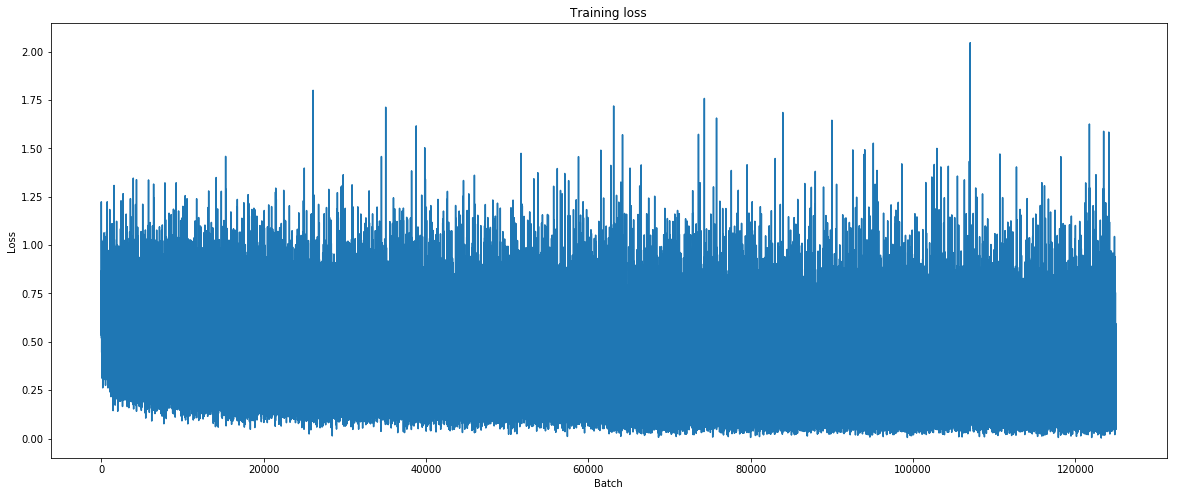

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

## Evaluation.

In [18]:
torch.cuda.empty_cache()
model = torch.load("/home/test/nbs/cberrio/data/XLNet-data/BERT_Test.pt")
model.eval()
preds = []

for i in range(int(len(test_inputs)/10)):
    batch = (test_inputs[i*10: (i+1)*10].to(device), test_masks[i*10: (i+1)*10].to(device))
    with torch.no_grad():
        logits = model(batch[0], token_type_ids=None, attention_mask = batch[1])[0]
    
    logits = logits.detach().cpu().numpy()
    preds.append(logits)
    if i%100 == 0:
        print("Processing: ", i*10/1000, "%")


Processing:  0.0 %
Processing:  1.0 %
Processing:  2.0 %
Processing:  3.0 %
Processing:  4.0 %
Processing:  5.0 %
Processing:  6.0 %
Processing:  7.0 %
Processing:  8.0 %
Processing:  9.0 %
Processing:  10.0 %
Processing:  11.0 %
Processing:  12.0 %
Processing:  13.0 %
Processing:  14.0 %
Processing:  15.0 %
Processing:  16.0 %
Processing:  17.0 %
Processing:  18.0 %
Processing:  19.0 %
Processing:  20.0 %
Processing:  21.0 %
Processing:  22.0 %
Processing:  23.0 %
Processing:  24.0 %
Processing:  25.0 %
Processing:  26.0 %
Processing:  27.0 %
Processing:  28.0 %
Processing:  29.0 %
Processing:  30.0 %
Processing:  31.0 %
Processing:  32.0 %
Processing:  33.0 %
Processing:  34.0 %
Processing:  35.0 %
Processing:  36.0 %
Processing:  37.0 %
Processing:  38.0 %
Processing:  39.0 %
Processing:  40.0 %
Processing:  41.0 %
Processing:  42.0 %
Processing:  43.0 %
Processing:  44.0 %
Processing:  45.0 %
Processing:  46.0 %
Processing:  47.0 %
Processing:  48.0 %
Processing:  49.0 %
Processing

In [3]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
predictions = []
for pred in preds:
    p = np.argmax(pred, axis = 1)
    for label in p:
        predictions.append(label)
print(classification_report(np.asarray(test["label"][:len(predictions)]), predictions, digits = 4))
print("Accuracy: ", accuracy_score(np.asarray(test["label"][:len(predictions)]), predictions))


### Metrics of the three models:

Gpt-2:
    - Accuracy: 0.85237
    - Precision: 0.8549
    - Recall: 0.8524
    - F1-score: 0.8509

BERT:
    - Accuracy: 0.8437
    - Precision: 0.8443
    - Recall: 0.8437
    - F1-score: 0.8439 

In [46]:
torch.save(model, "/home/test/nbs/cberrio/data/XLNet-data/Gpt2_Classifier_Large.pt")